In [2]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import audtorch
import torch
from torch import nn
from torch.nn.utils.rnn import *
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Thu Dec  3 20:47:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Connecting GDrive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/My\ Drive/Colab/IDL_Final_Project  
# %cd /content/gdrive/My\ Drive/IDL_Final_Project   

/content/gdrive/.shortcut-targets-by-id/1Sr9hCVVWERdsdT-sePtsjuVIxzvSrDI1/Colab/IDL_Final_Project


## Loading data

In [22]:
train_data = np.load("train_data.npy",allow_pickle=True)  
train_labels = np.load("train_labels.npy",allow_pickle=True)

test_data = np.load("test_data.npy",allow_pickle=True)  
test_labels = np.load("test_labels.npy",allow_pickle=True)

# Labels columns: age, height, gender
# age: years, height: centimeters, gender: 1-male, 0-female
train_labels[0]
# >> array([27.  ,  167.64,    0.  ])

array([ 27.  , 167.64,   0.  ])

In [23]:
# Shuffling data
train_indices = np.random.permutation(len(train_data))
train_data = train_data[train_indices]
train_labels = train_labels[train_indices]

test_indices = np.random.permutation(len(test_data))
test_data = test_data[test_indices]
test_labels = test_labels[test_indices]

Normalizing training Labels to have zero mean and unit standard deviation

In [24]:
tr_labels = train_labels.copy()

avg_age = tr_labels[:,0].mean()
std_age = tr_labels[:,0].std()

tr_labels[:,0] = (tr_labels[:,0] - avg_age)/std_age

# tes_labels[:,:-1] = (tes_labels[:,:-1] - tes_labels[:,:-1].mean(axis=0))/tes_labels[:,:-1].std(axis=0)

In [30]:
male_train_labels = tr_labels[tr_labels[:,-1] == 1]
m_tr_avg_age = male_train_labels[:,0].mean()

female_train_labels = tr_labels[tr_labels[:,-1] == 0]
f_tr_avg_age = female_train_labels[:,0].mean()

print("Female's avg age: ", f_tr_avg_age)
print("Male's avg age: ", m_tr_avg_age)

Female's avg age:  -0.056530944733449814
Male's avg age:  0.02341005380066171


In [21]:
male_test_labels = test_labels[test_labels[:,-1] == 1]
m_test_avg_age = male_test_labels[:,0].mean()

female_test_labels = test_labels[test_labels[:,-1] == 0]
f_test_avg_age = female_test_labels[:,0].mean()

print("Female's avg age: ", m_test_avg_age)
print("Male's avg age: ", f_test_avg_age)

Female's avg age:  31.229609929078013
Male's avg age:  31.045694200351495


In [ ]:
# Changing age to the average
# tr_labels = train_labels.copy()

# for idx in range(tr_labels.shape[0]):
  
#   if tr_labels[idx, -1] == 1:
#     tr_labels[idx, 0] = m_avg
#   else:
#     tr_labels[idx, 0] = f_avg

tes_labels = test_labels.copy()
for idx in range(tes_labels.shape[0]):
  
  if tes_labels[idx, -1] == 1:
    tes_labels[idx, 0] = m_tr_avg_age
  else:
    tes_labels[idx, 0] = f_tr_avg_age

## Dataset

In [8]:
class CustomDataset(Dataset):
  def __init__(self,data,labels=None):

    # lens = [utter.shape[0] for utter in data]
    # max_lens = max(lens) # The longest utterance in training data has 336 frames

    max_lens = 336  # Both train and test/val data must be equal in size

    pad_above = 0; pad_below = 0
    pad_left = 0; pad_right = 0
    
    self.X = []

    for utter in data:
      utter = np.pad(utter, pad_width=((pad_above, max_lens-utter.shape[0]),(pad_left, pad_right)))
      utter = torch.from_numpy(utter)
      utter = utter.T  # (64, 336)

      self.X.append(utter.type(torch.float32))

    # self.X = [torch.from_numpy(d) for d in data]

    if labels is not None:
      self.y = torch.from_numpy(labels) 
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X = self.X[idx]

    if self.y is not None:
      y = self.y[idx]

      return X, y
    else:
      return X, None

## Dataloader

### DataLoaders

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training
batch_size = 64

train_dataset = CustomDataset(train_data, train_labels) #train_labels
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, 
                          num_workers=4,drop_last=True) 

# Validation
val_dataset = CustomDataset(test_data, test_labels)
validation_loader = DataLoader(val_dataset, shuffle=False,batch_size=batch_size, 
                               num_workers=4, drop_last=True)

In [15]:
 
# conv 32, relu, conv 64, relu, conv 128 relu,  meanpool (down to a 128-d vector),  linear layre for prediction.
# cnn1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, bias=False)  # #([64, 32, 325])

# cnn2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, stride=2, bias=False) # #([64, 64, 163])

# cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=2, bias=False) #([64, 128, 81])

# pool = nn.AvgPool1d(2, stride=2)  #([64, 128, 40])

# CONV 2D
cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, bias=False)  # ([64, 32, 63, 335])

cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, bias=False) # ([64, 64, 32, 168])

cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, bias=False) # ([64, 128, 16, 84])

pool = nn.AvgPool2d((3,3))  # ([64, 128, 8, 42])

# linear = nn.Linear(128 * 21 * 111, 1)
# nn.BatchNorm2d(channel_out)

for inputs, labels in train_loader:
  inp = inputs.unsqueeze(1)  # ([64, 64, 327])

  print("in",inp.size())

  out = cnn1(inp)  #([64, 32, 325])
  print("CNN1 out", out.size())

  out = cnn2(out)  #([64, 64, 163])
  print("CNN2 out", out.size())

  out = cnn3(out)  #([64, 128, 81])
  print("CNN3 out", out.size())

  out = pool(out)  #([64, 128, 40])
  print("Pool out", out.size())

  # out = out.view(out.size(0), -1)
  # out = linear(out)
  # print("Linear out", out.size())

  break

in torch.Size([64, 1, 64, 336])
CNN1 out torch.Size([64, 32, 32, 168])
CNN2 out torch.Size([64, 64, 32, 168])
CNN3 out torch.Size([64, 128, 32, 168])
Pool out torch.Size([64, 128, 10, 56])


## Model

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # conv 32, relu, conv 64, relu, conv 128 relu,  meanpool (down to a 128-d vector),  linear layre for prediction.

        self.cnns = nn.Sequential(  # input size => ([64, 64, 327])
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, bias=False), #out => ([64, 32, 325])
            nn.ReLU(), nn.BatchNorm1d(32),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=2, bias=False), #out => ([64, 64, 163])
            nn.ReLU(), nn.BatchNorm1d(64),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=2, bias=False), #out => ([64, 128, 81])
            nn.ReLU(), nn.BatchNorm1d(128),
            
            nn.AvgPool1d(2, stride=2)  # out => ([64, 128, 40])
            # nn.MaxPool1d(2, stride=2)
        )

        self.fc_age = nn.Linear(128 * 41, 1)
        self.fc_gender = nn.Linear(128 * 41, 2)
    
    def forward(self, batch_data): 

      out = self.cnns(batch_data) #1D CNN
      # out = self.cnns(batch_data.unsqueeze(1))  # 2D CNN
      
      out = out.view(out.size(0), -1)
      
      out_age = self.fc_age(out)  # Reshapes to (batch, 128 * 41)

      out_gender = self.fc_gender(out)  #

      return out_age.view(-1), out_gender


def init_weights(m):
  if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
    nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
     
  elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
    nn.init.constant_(m.weight, 1)
    nn.init.constant_(m.bias, 0)

## Training

### Validate

In [12]:
def validate(model,validation_loader):
  model.eval()
  running_loss_v = 0.0
  correct_v = 0
  total_v = 0

  with torch.no_grad():
    
    for batch_idx, (X, y) in enumerate(validation_loader):
      
      X = X.to(device)
      y = y.to(device)

      age_pred, gender_pred = model(X)

      loss = criterion(age_pred,y[:,0])

      preds = age_pred.cpu().numpy()

      running_loss_v += loss.item()

      # print('Batch val loss', loss.item())
      total_v += y.size(0)


      torch.cuda.empty_cache()
      del X; del y
      del age_pred; del gender_pred
      del loss


  avg_loss_v = running_loss_v / len(validation_loader)

  return avg_loss_v

### Train method

In [17]:
def train():

  total_loss = []
  running_loss = 0.0
  total = 0

  val_avg_loss = []
  train_avg_loss_list = []

  for epoch in range(NUM_EPOCHS):
    print("EPOCH #",epoch + 1)
    
    model.train()  # Re-enabling training
    
    start = time.time()

    for batch_idx, (X, y) in enumerate(train_loader):

      optimizer.zero_grad()

      X = X.to(device)
      y = y.to(device)

      t0 = time.time()

      age_pred, gender_pred = model(X)
      
      loss_age = criterion(age_pred,y[:,0])

      # _, gender_v = torch.max(F.softmax(gender_pred, 1), 1)

      true_gender = y[:,-1].long()

      # print(gender_pred.size(), gender_v.size(), true_gender.size())
      # print(gender_v, true_gender)

      # loss_gender = criterion2(gender_v, true_gender) 
      loss_gender = criterion2(gender_pred, true_gender) 

      #Adding losses for MTL
      beta = 0.25
      loss = loss_gender + beta* loss_age

      running_loss += loss.item()
      total += y.size(0)


      if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
        print('[Batch {}]\tLoss: {}, Age Loss: {}, Gender Loss: {}'.format(batch_idx + 1, loss.item(), loss_age.item(), loss_gender.item()))

      t1 = time.time()

      loss.backward()

      t2 = time.time()
      
      if batch_idx == 0 and epoch == 0:
        print("Model Prediction time: ", t1 - t0)
        print("Loss Backward computation time: ", (time.time() - t2))

      optimizer.step()
      # scheduler.step()
      scheduler.step(loss)


      torch.cuda.empty_cache()
      del X; del y
      del age_pred  #; del height_prediction
      # del loss1; del loss2
      del loss

    train_avg_loss = running_loss / total

    # Validating
    t0 = time.time()
    validation_avg_loss = validate(model,validation_loader)
    running_loss/= len(train_loader)
    total_loss.append(running_loss)
    train_avg_loss_list.append(train_avg_loss)

    val_avg_loss.append(validation_avg_loss)

    if epoch == 0:
      print("Validation time: ", (time.time() - t0))
      print("Epoch duration time: ", (time.time() - start))
      print("*" * 30)
      print("")

    print('Epoch [%d] [train] loss: %.8f' %(epoch + 1, train_avg_loss))
    print('[running] loss: %.8f' % (running_loss))
    print('[valid] loss: %.8f' % (validation_avg_loss))
    print("-" * 30)

    if len(val_avg_loss) >= 2 and val_avg_loss[-1] > val_avg_loss[-2]:
      print("Stopped. Model started overfitting data")
      break

  return val_avg_loss

### main

In [18]:
NUM_EPOCHS = 10 #100

learning_rate = 1e-01  # Best with ADAM: 1e-01

input_size = 64

model = Model()
model.apply(init_weights)

model.to(device)

criterion = nn.L1Loss() #nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=5e-06)
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=20, threshold=0.01, verbose=True)

val_avg_loss = train()

EPOCH # 1
Model Prediction time:  0.0040400028228759766
Loss Backward computation time:  0.00022792816162109375
[Batch 10]	Loss: 18.176026799716055, Age Loss: 23.192106161266565, Gender Loss: 12.378000259399414
[Batch 20]	Loss: 8.778185862582177, Age Loss: 19.21007831208408, Gender Loss: 3.9756662845611572
[Batch 30]	Loss: 5.104372928151861, Age Loss: 16.46481303218752, Gender Loss: 0.9881696701049805
[Batch 40]	Loss: 3.3540339209139347, Age Loss: 10.064165011048317, Gender Loss: 0.8379926681518555
[Batch 50]	Loss: 3.38053076621145, Age Loss: 10.48390432819724, Gender Loss: 0.7595546841621399
[Batch 60]	Loss: 3.9279256090521812, Age Loss: 10.307434171438217, Gender Loss: 1.351067066192627
[Batch 70]	Loss: 2.1339782818686217, Age Loss: 7.553932326845825, Gender Loss: 0.24549520015716553
[Batch 72]	Loss: 3.4513000026345253, Age Loss: 6.828686624765396, Gender Loss: 1.7441283464431763
Validation time:  0.3590829372406006
Epoch duration time:  1.317620038986206
****************************

In [ ]:
from time import time
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': learning_rate,
            'hidden_size': hidden_size,
            'dropout': dropout,
            'layers': nlayers,
            'val_loss':val_avg_loss[-1] 
        }, "Model_avg_age_"+str(time())+".model")

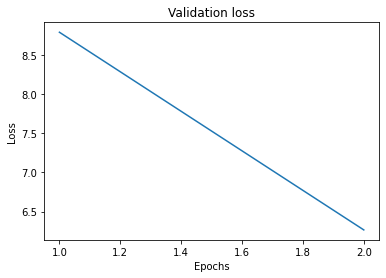

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.gcf()

plt.plot(list(range(1,len(val_avg_loss) + 1)), val_avg_loss)
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Validation loss')

plt.show()
plt.draw()
# fig.savefig('avg_age_loss_lr1_{}_data_{}.png'.format(learning_rate,len(train_labels)), dpi=100)

## L1 Loss and L2 Loss on Test data

In [ ]:
model.eval()

predictions = []
targets = []

with torch.no_grad():
  for batch_idx, (X, y) in enumerate(validation_loader):

    X = X.to(device)

    output, _ = model(X)

    pred = output.cpu().numpy()

    predictions.extend(pred.tolist())
    targets.extend(y[:,[0,-1]].numpy().tolist())

    torch.cuda.empty_cache()
    del X;
    del output

In [ ]:
predictions = torch.Tensor(predictions)
targets = torch.Tensor(targets)

mae_loss = nn.L1Loss() 
mse_loss = nn.MSELoss()

l1 = mae_loss(predictions, targets[:,0])
l2 = mse_loss(predictions, targets[:,0])

print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  7.2083740234375
MSE:  126.23200225830078


### MALE

In [ ]:
index = targets[:,1] == 1

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

Avg:  28.616224
MAE:  6.558823108673096
MSE:  93.9830551147461


### FEMALE

In [ ]:
index = targets[:,1] == 0

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

Avg:  28.029867
MAE:  8.509822845458984
MSE:  190.8463134765625


## Losses with Actual Test labels

In [ ]:
validation_dataset = CustomDataset(test_data, test_labels)#test_labels
test_loader = DataLoader(validation_dataset, shuffle=False, 
                               batch_size=batch_size, num_workers=4)

In [ ]:
model.eval()

predictions = []
targets = []

with torch.no_grad():
  for batch_idx, (X, y) in enumerate(test_loader):

    X = X.to(device)

    output, _ = model(X)

    pred = output.cpu().numpy()

    predictions.extend(pred.tolist())
    targets.extend(y[:,[0,-1]].numpy().tolist())

    torch.cuda.empty_cache()
    del X;
    del output

In [ ]:
# avg_age = test_labels[:,0].mean()  #test_labels
# std_age = test_labels[:,0].std()

# avg_age = tr_labels[:,0].mean()
# std_age = tr_labels[:,0].std()
avg_age

30.570498915401302

In [ ]:
pred = predictions #(predictions + avg_age) #* std_age

print(min(pred))
print(max(pred))
# predictions

-2.1922659873962402
58.04458999633789


In [ ]:
predictions = torch.Tensor(pred) #predictions
targets = torch.Tensor(targets)

mae_loss = nn.L1Loss() 
mse_loss = nn.MSELoss()

In [ ]:
targets[:, 0]

tensor([28., 30., 31.,  ..., 25., 28., 33.])

### Male

In [ ]:
index = targets[:,1] == 1

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  5.900014877319336
MSE:  81.12384796142578


### Female

In [ ]:
index = targets[:,1] == 0

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

#print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  7.089176177978516
MSE:  114.06756591796875
